# Receiver Operating Characteristic (ROC) Curve on Iris

In this notebook we find an example of Receiver Operating Characteristic (ROC) Curves.

An ROC curve represents the discriminative ability of a binary classification in a graphical plot. In an ROC curve the true positive rate of the binary classification on the Y axis is plotted against the false positive rate of the binary classification on the X axis.

In this example we analyze the discriminative ability of a SVM classifier on the Iris dataset. Because the Iris dataset contains more than two classes the SVM classifier will not be a binary classification. Therefore it is neccesary to binarize the output of the SVM classifier with a One v.s. Rest classifier. This means that for each class (Iris has three classes) we obtain one ROC curve representing the discriminative ability of the SVM of this class agains the other classes.

Before we showcase pyroc, we show how to generate the ROC curves with SKLearn using [code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

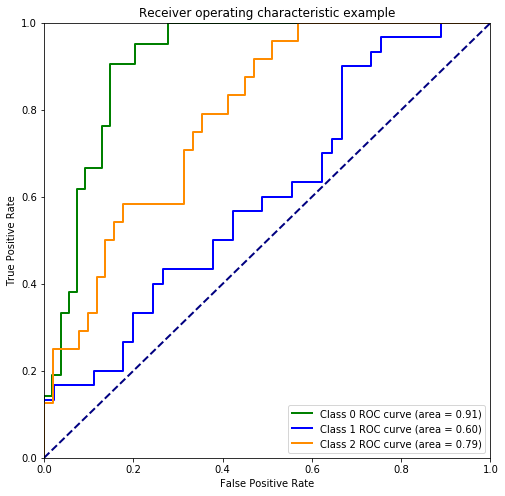

In [2]:
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr[0], tpr[0], color='green',
         lw=lw, label='Class 0 ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue',
         lw=lw, label='Class 1 ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='Class 2 ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

With pyroc we draw the same ROC curves. But this time we add the confidence interval (p = 0.05) to the ROC curves.

In [3]:
import pyroc

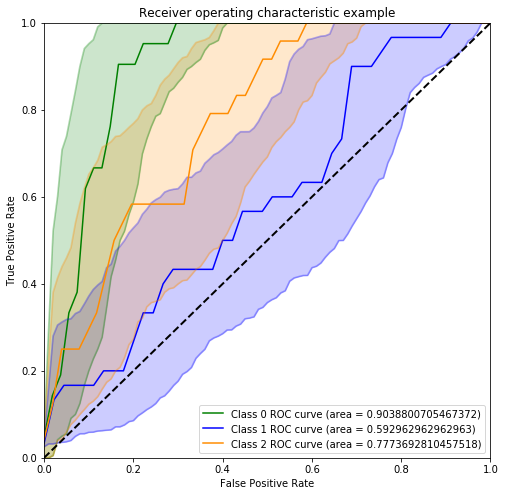

In [4]:
roc0 = pyroc.ROC(y_test[:, 0], y_score[:, 0])
roc1 = pyroc.ROC(y_test[:, 1], y_score[:, 1])
roc2 = pyroc.ROC(y_test[:, 2], y_score[:, 2])

fig, ax = plt.subplots(figsize=(8, 8))

roc0.plot(
    x_label='False Positive Rate',
    y_label='True Positive Rate',
    title='Receiver operating characteristic example',
    label=f'Class 0 ROC curve (area = {roc0.auc})',
    color='green',
    bootstrap=True,
    ax=ax)
roc1.plot(
    x_label='False Positive Rate',
    y_label='True Positive Rate',
    title='Receiver operating characteristic example',
    label=f'Class 1 ROC curve (area = {roc1.auc})',
    color='blue',
    bootstrap=True,
    ax=ax)
roc2.plot(
    x_label='False Positive Rate',
    y_label='True Positive Rate',
    title='Receiver operating characteristic example',
    label=f'Class 2 ROC curve (area = {roc2.auc})',
    color='darkorange',
    bootstrap=True,
    ax=ax)
ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')

ax.legend(loc="lower right")

Not only is it possible to draw the ROC curve confidence intervals. We can also compare the three ROC curves to determine which ROC is "best". To explain "best" we must understand that we can compare ROC curves using the DeLong method. Given two ROC curves `roc0` and `roc1`. We say that `roc1 < roc0` if we can reject the zero hypothesis `roc1 > roc0` with a p-value greater than 0.05. To compute the p-value for rejecting the zero hypothesis we compute the bootstraps for `roc0` and `roc1`. For each bootstrap we compute the Area Under the Curve `auc0` and `auc1` for the bootstraps of `roc0` and `roc1` respectively. Finally we assume that the average of all `auc0 / auc1` is sampled from a Gaussian distribution. To compute the p-value for rejecting the zero hypothesis we apply the [Z-test](https://en.wikipedia.org/wiki/Z-test).

In [5]:
cmp, p_value = pyroc.compare_bootstrap(roc1, roc0)
print(f'Is roc1 < roc0: {cmp} (p-value = {p_value:.06f})')

cmp, p_value = pyroc.compare_bootstrap(roc2, roc0)
print(f'Is roc2 < roc0: {cmp} (p-value = {p_value:.03f})')

cmp, p_value = pyroc.compare_bootstrap(roc1, roc2)
print(f'Is roc1 < roc2: {cmp} (p-value = {p_value:.03f})')

Is roc1 < roc0: True (p-value = 0.000014)
Is roc2 < roc0: True (p-value = 0.021)
Is roc1 < roc2: True (p-value = 0.019)
